In [1]:
# Description:
# This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM)
# to predict the closing stock price of a corporation (Apple Inc.) using the past 60 day stock price.

In [2]:
#Import the libraries
from datetime import datetime, timedelta
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
# import math
import pandas_datareader as web
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [9]:
# load dataset

tickers = ['MSFT',
           '^GSPC', # S&P 500
#            'AAPL',
#            'AMZN',
#            'GOOG',
           'EXPE', # MSFT CUSTOMER
#            'FB',
           'BA', # MSFT CUSTOMER
           'SSNLF', # MSFT CUSTOMER
           'GE', # MSFT CUSTOMER
           'BMWYY' # MSFT CUSTOMER \
#            'INTC',
#            'NVDA',
#            'PYPL',
#            'CRM', \
#            'TSLA',
#            'AMD',
#            'ATVI',
#            'EA',
#            'MTCH',
#            'TTD',
#            'ZG',
#            'YELP',
#            'TIVO' \
          ]

data_source='yahoo'

today = datetime.strftime(datetime.today(), '%Y-%m-%d')

start='2020-02-25'
train_end_t_minus = 0 
end=(datetime.strftime(datetime.now() - timedelta(train_end_t_minus), '%Y-%m-%d'))
predict_n = 10
memory = 60
Y = 'MSFT'

print(" TICKERS:\n\t", '\n\t '.join(map(str, tickers)),
    "\n Today's date:", today, "\n",
      "Model will train on timewindow:" ,
      "\n\t from %s" %start,
      "\n\t from %s" %end,
     "\n model will predict %s period steps in the future" %predict_n)

#Get the stock quote 
df_o = pd.DataFrame()

for ticker in tickers:
    d=(web.DataReader(ticker, data_source=data_source, start=start, end=end).reset_index()[['Date', 'Close', 'Open']])
    d = d.rename(columns={"Close": "C_" + ticker, "Open": 'O_' + ticker})
    if df_o.empty:
        df_o=d
    else:
        df_o = pd.merge(df_o,d, on='Date')
        
df_o = df_o.set_index('Date')
df_o.shape

s1 = df_o.reset_index().melt(id_vars='Date')
s1['ticker'] = s1['variable'].str[2:]
s1['day_part'] = s1['variable'].str[0:1]
s1 = s1.pivot_table(index=['Date', 'day_part'], columns='ticker', values = 'value').reset_index()
s1.loc[s1['day_part'] == "O",'Date'] = s1.loc[s1['day_part'] == "O", 'Date'] + pd.DateOffset(hours=9, minutes=30)
s1.loc[s1['day_part'] == "C",'Date'] = s1.loc[s1['day_part'] == "C", 'Date'] + pd.DateOffset(hours=16, minutes = 0)

df = s1.sort_values(by=['Date'])
df = df.drop(['day_part'], axis=1)
df = df.set_index('Date').reset_index()


#Scale the all of the data to be values between 0 and 1 
x_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = df[tickers]

# for ticker in tickers:
y_scaler.fit(scaled_data[Y].values.reshape(-1,1))

scaled_data = pd.DataFrame(x_scaler.fit_transform(scaled_data[tickers]), columns=tickers)

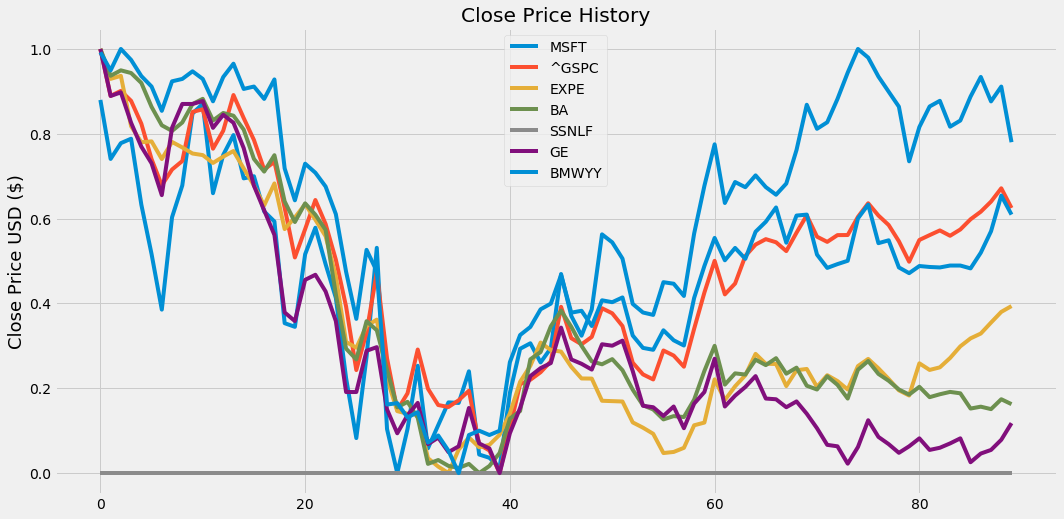

In [13]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(scaled_data[tickers])
# plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.legend(tickers)
plt.show()

In [18]:
#Create the scaled data set 
train_data = scaled_data.values

#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(memory,len(train_data)):
    x_train.append(train_data[i-memory:i,:])
    y_train.append(train_data[i,0])
    
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],len(tickers)))

In [19]:
# load model
model = load_model('MSFT_forecast.mdl_wts.hdf5')
# summarize model.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 50)            11600     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 33,101
Trainable params: 33,101
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Now get the predicted values from the model using the test data.
#Getting the models predicted price values
predictions = model.predict(x_train)
predictions = y_scaler.inverse_transform(predictions) #Undo scaling

# Get the root mean squared error (RMSE), which is a good measure of how accurate the model is. A value of 0 would indicate that the models predicted values match the actual values from the test data set perfectly.
# The lower the value the better the model performed. But usually it is best to use other metrics as well to truly get an idea of how well the model performed.
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions - y_train)**2)))
rmse

169.76671372562672

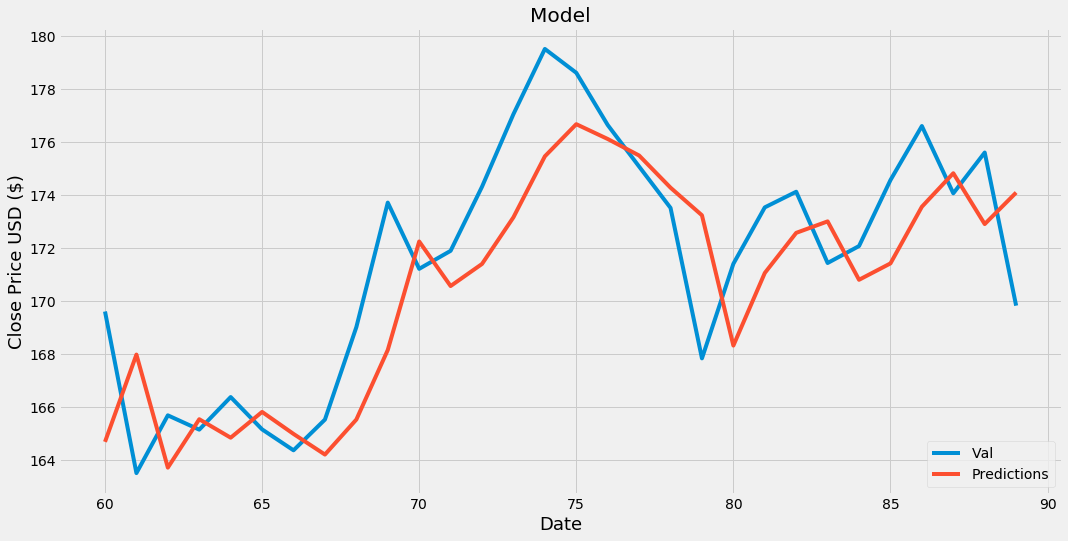

In [47]:
# The RMSE value
# Let’s plot and visualize the data.
# Plot/Create the data for the graph
# train = dataset[:training_data_len]
valid = df.loc[memory:,:]
valid.loc[memory:,'Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
# plt.plot(train[Y])
plt.plot(valid[[Y, 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Graph showing the training (train), actual (valid) and predicted (predictions) prices.
# Show the valid and predicted prices.
valid.tail()

plt.figure(figsize=(16,8))
plt.title('Error')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Squared Error', fontsize=18)
# plt.plot(valid['Close']-valid['Predictions'])
plt.plot(valid[[Y, 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
start_cash = 1000
calc_df = pd.DataFrame()

# v = valid.loc['2019-08-01':'2019-09-01'][[Y,'Predictions']]

calc_df = valid.loc[:][[Y,'Predictions']]
calc_df.loc[:,"prev_pred"] = calc_df['Predictions'].shift(1)
calc_df.loc[:,"prev_close"] = calc_df[Y].shift(1)
calc_df.loc[:,'pred_growth'] = calc_df['Predictions'] / calc_df["prev_pred"]
calc_df.loc[:,'pred_growth'] = calc_df.loc[:,'pred_growth'].shift(-1)
calc_df.loc[:,'close_growth'] = calc_df[Y] / calc_df["prev_close"]
calc_df.loc[:,'cash'] = '-'
calc_df.loc[:,'bid'] = 0

vcols = ['Date', 'Predictions','MSFT','prev_pred','prev_close','pred_growth','close_growth','cash','bid']
# v = v[vcols]


def buy(i, data, balance_col='cash', bid_col='bid'):
    data.loc[i,balance_col] = data.loc[i-1,balance_col]
    data.loc[i,bid_col] = data.loc[i,balance_col]
    data.loc[i,balance_col] = 0


def sell(i, data, balance_col='cash', bid_col='bid', actual_growth = 'close_growth'):
    data.loc[i,balance_col] = data.loc[i-1,bid_col] * data.loc[i,actual_growth]
    data.loc[i,bid_col] = 0
    
def hold_bid(i, data, balance_col='cash', bid_col='bid', actual_growth = 'close_growth'):
    data.loc[i,bid_col] = data.loc[i-1,bid_col] * data.loc[i,actual_growth]
    data.loc[i,balance_col] = 0
    
def hold_cash(i, data, balance_col='cash', bid_col='bid'):
    data.loc[i,balance_col] = data.loc[i-1,balance_col]


# buy_thr = 1.04
# sel_thr = 0.98

opt_buy_thr = '-'
opt_sel_thr = '-'
max_balance = '-'
opt_history = pd.DataFrame()
parameter_hist = {'bt': [],
                 'st':[],
                 'balance':[]}


for buy_thr in np.arange(1,max(calc_df['pred_growth']),(max(calc_df['pred_growth'])-1)/100):
#   print(buy_thr)
    
    for sel_thr in np.arange(min(calc_df['pred_growth']),1,(1-min(calc_df['pred_growth']))/100):
        v = calc_df.reset_index()
    
        for i, row in v.iterrows():
            # jelentős növekedés várható
            if i == 0:
                v.loc[i,'cash'] = start_cash
#             elif v.loc[i, 'close_growth']
            if (row['pred_growth'] > buy_thr) and (i > 0):
                # és már van bent bid
                if v.loc[i-1,'bid'] > 0:
                    hold_bid(i, data = v)
        #         ha nincs bent bid -> vétel
                else:
                    buy(i, data = v)    

            # ha jelentős csökkenés várható 
            elif (row['pred_growth'] < sel_thr) and (i > 0):
                # ÉS nincs bent bid akkor cash  =  cash(T-1)
                if v.iloc[i-1]['bid'] <= 0:
                    hold_cash(i, data = v)
                # ÉS van már bent bid akkor ELADÁS
                else:
                    sell(i, data = v)

            # ha semlegesek a várakozások
            elif (row['pred_growth'] <= buy_thr) and (row['pred_growth'] >= sel_thr) and (i > 0):
                # ÉS nincs bent bid akkor cash  =  cash(T-1)
                if v.iloc[i-1]['bid'] <= 0:
                    hold_cash(i, data = v)
                # ÉS van már bent bid akkor NO ACTION
                else:
                    hold_bid(i, data = v)
        if (v.tail(2).head(1)['bid'].values[0] < v.tail(2).head(1)['cash'].values[0]):
            balance = v.tail(2).head(1)['cash'].values[0]
        else:
            balance = v.tail(2).head(1)['bid'].values[0]
        
        parameter_hist['balance'].append(balance)
        parameter_hist['bt'].append(buy_thr)
        parameter_hist['st'].append(sel_thr)
        
        if max_balance == '-' or max_balance < balance:
            opt_buy_thr = buy_thr
            opt_sel_thr = sel_thr
            max_balance = balance
            opt_history = v


In [ ]:
parameter_hist = pd.DataFrame.from_dict(parameter_hist)

from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(parameter_hist['bt'], parameter_hist['st'], parameter_hist['balance'], c=parameter_hist['balance'], cmap='Greens');

In [ ]:
f_par_hist = parameter_hist[ #(parameter_hist['balance'] != max(parameter_hist['balance'])) &
              (parameter_hist['st'] > min(parameter_hist['st'])) &
              (parameter_hist['bt'] < max(parameter_hist['bt']))]

pyplot.scatter(f_par_hist['balance'], f_par_hist['bt'], label='bt')
pyplot.scatter(f_par_hist['balance'], f_par_hist['st'], label='st')
# pyplot.plot(parameter_hist['balance'], label='balance')
pyplot.legend()
pyplot.show()

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(f_par_hist['bt'], f_par_hist['st'], c=f_par_hist['balance'], cmap="inferno",s=5)
# pyplot.scatter(f_par_hist['balance'], f_par_hist['st'], label='st')
# pyplot.plot(parameter_hist['balance'], label='balance')
legend1 = ax.legend(*scatter.legend_elements(num=15),
                    loc='lower right', title="Ranking")
ax.add_artist(legend1)
fig.show()

In [ ]:
opt_buy_thr, opt_sel_thr, max_balance 

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
opt_history